In [1]:
!pip -q install -U keras-tuner gputil

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [2]:
import os, time, json, platform, gc, timeit, math
import numpy as np
import pandas as pd
import GPUtil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from keras import ops as K
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Colab: mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Paths
BASE_PATH = "/content/drive/MyDrive/EdgeMeter_AIv2/data"
WIN_KEY   = "48to12"
WIN_TAG   = "48_12"

HP_JSON_PRIMARY   = os.path.join(BASE_PATH, f"best_liteformer_hp_{WIN_KEY}.json")
HP_JSON_FALLBACK  = os.path.join(BASE_PATH, f"liteformer_tuning_log_{WIN_KEY}.json")
TRAIN_LOG_PATH    = os.path.join(BASE_PATH, "liteformer_training_log_48_12.json")

In [5]:
# Data
X_train = np.load(os.path.join(BASE_PATH, f"X_train_{WIN_TAG}.npy"))
y_train = np.load(os.path.join(BASE_PATH, f"y_train_{WIN_TAG}.npy"))
X_val   = np.load(os.path.join(BASE_PATH, f"X_val_{WIN_TAG}.npy"))
y_val   = np.load(os.path.join(BASE_PATH, f"y_val_{WIN_TAG}.npy"))
X_test  = np.load(os.path.join(BASE_PATH, f"X_test_{WIN_TAG}.npy"))
y_test  = np.load(os.path.join(BASE_PATH, f"y_test_{WIN_TAG}.npy"))

assert X_train.ndim==3 and X_val.ndim==3 and X_test.ndim==3, "X must be (N,T,F)"
assert y_train.shape[1]==12 and y_val.shape[1]==12 and y_test.shape[1]==12, "Expect 12-step output"

timesteps, n_features = X_train.shape[1], X_train.shape[2]
print(f"Train X: {X_train.shape} | y: {y_train.shape}")
print(f"Val   X: {X_val.shape}   | y: {y_val.shape}")
print(f"Test  X: {X_test.shape}  | y: {y_test.shape}")

Train X: (10719826, 48, 11) | y: (10719826, 12)
Val   X: (3072784, 48, 11)   | y: (3072784, 12)
Test  X: (1536392, 48, 11)  | y: (1536392, 12)


In [6]:
# GPU info
gpus = tf.config.list_physical_devices('GPU')
print("GPUs visible to TF:", gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except Exception:
        pass
gpu_name = GPUtil.getGPUs()[0].name if GPUtil.getGPUs() else "None"
print("GPU in use:", gpu_name)

GPUs visible to TF: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU in use: NVIDIA A100-SXM4-40GB


In [7]:
print(f"Test  X: {X_test.shape}  | y: {y_test.shape}")

# GPU info
gpus = tf.config.list_physical_devices('GPU')
print("GPUs visible to TF:", gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except Exception:
        pass
gpu_name = GPUtil.getGPUs()[0].name if GPUtil.getGPUs() else "None"
print("GPU in use:", gpu_name)



Test  X: (1536392, 48, 11)  | y: (1536392, 12)
GPUs visible to TF: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU in use: NVIDIA A100-SXM4-40GB


In [8]:
# Loading Best Hyperparameters
def load_best_hps():
    if os.path.exists(HP_JSON_PRIMARY):
        with open(HP_JSON_PRIMARY, "r") as f:
            return json.load(f)
    with open(HP_JSON_FALLBACK, "r") as f:
        fb = json.load(f)
    return fb["best_hyperparameters"]

best_hps = load_best_hps()
print("Best HPs:", best_hps)

Best HPs: {'patch_size': 12, 'hidden_dim': 96, 'dropout': 0.0, 'learning_rate': 0.0002050081613348783}


In [9]:
# LiteFormer
def slice_patches(x, patch_size):
    """(B, T, F) -> (B, P, patch_size*F) with floor division over T."""
    T = K.shape(x)[1]
    F = K.shape(x)[2]
    t_trim = (T // patch_size) * patch_size
    x = x[:, :t_trim, :]
    P = t_trim // patch_size
    return K.reshape(x, [K.shape(x)[0], P, patch_size * F])

def build_liteformer_from_hp(input_shape, hp_dict):
    T, F = input_shape
    patch_size = int(hp_dict["patch_size"])
    hidden_dim = int(hp_dict["hidden_dim"])
    dropout    = float(hp_dict["dropout"])
    lr         = float(hp_dict["learning_rate"])

    # Model
    inputs = keras.Input(shape=(T, F))

    # Patching
    x = layers.Lambda(lambda t: slice_patches(t, patch_size))(inputs)  # (B, P, patch_size*F)

    # Project to hidden_dim
    x = layers.Dense(hidden_dim)(x)

    # Learnable positional embedding over P patches
    num_patches = T // patch_size
    pos_embed = layers.Embedding(input_dim=num_patches, output_dim=hidden_dim)
    positions = K.arange(0, num_patches)  # Keras ops (safe with KerasTensors)
    pos_encoding = pos_embed(positions)   # (P, hidden_dim)
    x = x + pos_encoding                  # broadcast over batch

    # Pre-attention transform
    x = layers.Dense(hidden_dim, activation='gelu')(x)
    x = layers.Dropout(dropout)(x)

    # Lightweight attention
    q = layers.Dense(hidden_dim)(x)
    k = layers.Dense(hidden_dim)(x)
    v = layers.Dense(hidden_dim)(x)
    scale = K.sqrt(K.cast(hidden_dim, "float32"))
    attn_scores  = K.matmul(q, K.swapaxes(k, -1, -2)) / scale
    attn_weights = K.softmax(attn_scores, axis=-1)
    attn_output  = K.matmul(attn_weights, v)
    attn_output  = layers.Dropout(dropout)(attn_output)

    # Residual + Norm + FFN
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dense(hidden_dim * 2, activation='gelu')(x)
    x = layers.Dense(hidden_dim)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Head
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(12)(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=["mae"]
    )
    return model



In [10]:
# Build model
input_shape = (timesteps, n_features)
model = build_liteformer_from_hp(input_shape, best_hps)
model.summary()

# Callbacks
early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr  = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 4, 132)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4, 96)     │     12,768 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 4, 96)     │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4, 96)     │      9,312 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4, 96)     │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4, 96)     │      9,312 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4, 96)     │      9,312 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ swapaxes (Swapaxes) │ (None, 96, 4)     │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ matmul (Matmul)     │ (None, 4, 4)      │          0 │ dense_2[0][0],    │
│                     │                   │            │ swapaxes[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 4, 4)      │          0 │ matmul[0][0]      │
│ (TrueDivide)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 4, 4)      │          0 │ true_divide[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 4, 96)     │      9,312 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ matmul_1 (Matmul)   │ (None, 4, 96)     │          0 │ softmax[0][0],    │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 4, 96)     │          0 │ matmul_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 4, 96)     │          0 │ dropout[0][0],    │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 4, 96)     │        192 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4, 192)    │     18,624 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 4, 96)     │     18,528 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 4, 96)     │        192 │ dense_6[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 96)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 88,716 (346.55 KB)

 Trainable params: 88,716 (346.55 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# ====== Train ======
start_time = time.time()
device = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"
with tf.device(device):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=512,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
end_time = time.time()

Epoch 1/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 111s 5ms/step - loss: 0.0631 - mae: 0.1346 - val_loss: 0.0442 - val_mae: 0.1220 - learning_rate: 2.0501e-04
Epoch 2/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - loss: 0.0438 - mae: 0.1101 - val_loss: 0.0428 - val_mae: 0.1166 - learning_rate: 2.0501e-04
Epoch 3/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 76s 4ms/step - loss: 0.0426 - mae: 0.1080 - val_loss: 0.0425 - val_mae: 0.1177 - learning_rate: 2.0501e-04
Epoch 4/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 76s 4ms/step - loss: 0.0421 - mae: 0.1070 - val_loss: 0.0417 - val_mae: 0.1087 - learning_rate: 2.0501e-04
Epoch 5/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 76s 4ms/step - loss: 0.0417 - mae: 0.1061 - val_loss: 0.0415 - val_mae: 0.1106 - learning_rate: 2.0501e-04
Epoch 6/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 76s 4ms/step - loss: 0.0415 - mae: 0.1056 - val_loss: 0.0414 - val_mae: 0.1093 - learning_rate: 2.0501e-04
Epoch 7/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 76s 4ms/step - loss: 0.0417 - mae: 0.1057 - val_l

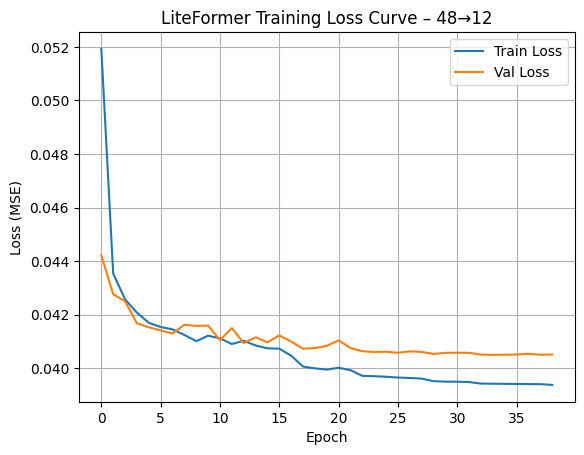

In [12]:
# Saving training history/curve
hist_df = pd.DataFrame(history.history)
hist_df.to_csv(os.path.join(BASE_PATH, "LiteFormer_Training_History_48_12.csv"), index=False)

plt.figure()
plt.plot(hist_df["loss"], label="Train Loss")
plt.plot(hist_df["val_loss"], label="Val Loss")
plt.title("LiteFormer Training Loss Curve – 48→12")
plt.xlabel("Epoch"); plt.ylabel("Loss (MSE)")
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(BASE_PATH, "LiteFormer_Training_Curve_48_12.png"))
plt.show()

In [13]:
# Saving GPU-trained weights
WEIGHTS_PATH = os.path.join(BASE_PATH, "LiteFormer_48_12_trained.weights.h5")
model.save_weights(WEIGHTS_PATH)
print(f" Saved GPU-trained weights to {WEIGHTS_PATH}")


 Saved GPU-trained weights to /content/drive/MyDrive/EdgeMeter_AIv2/data/LiteFormer_48_12_trained.weights.h5


In [14]:
# Evaluation
y_pred = model.predict(X_test, batch_size=1024, verbose=0)
test_mae  = mean_absolute_error(y_test, y_pred)
test_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
test_r2   = r2_score(y_test, y_pred)

In [15]:
# Export models
SAVE_DIR   = os.path.join(BASE_PATH, "Final_LiteFormer_Model_48_12")
SAVE_H5    = os.path.join(BASE_PATH, "Final_LiteFormer_Model_48_12.h5")
SAVE_KERAS = os.path.join(BASE_PATH, "Final_LiteFormer_Model_48_12.keras")

model.export(SAVE_DIR)   # TF SavedModel (Keras 3)
model.save(SAVE_H5)      # HDF5
model.save(SAVE_KERAS)   # .keras

Saved artifact at '/content/drive/MyDrive/EdgeMeter_AIv2/data/Final_LiteFormer_Model_48_12'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 11), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  133657430719376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657430719184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657430608016: TensorSpec(shape=(4, 96), dtype=tf.float32, name=None)
  133657430717456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657430718992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657430719760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657430606096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657430719568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657430605904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657430609168: TensorSpec(s

In [16]:
# Size helpers
def get_dir_size_mb(path):
    total_size = 0
    for dirpath, _, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.isfile(fp):
                total_size += os.path.getsize(fp)
    return total_size / 1e6

size_savedmodel_mb = get_dir_size_mb(SAVE_DIR)
size_h5_mb    = os.path.getsize(SAVE_H5) / 1e6 if os.path.exists(SAVE_H5) else None
size_keras_mb = os.path.getsize(SAVE_KERAS) / 1e6 if os.path.exists(SAVE_KERAS) else None


   usage_bin       MAE      RMSE        R2
0          0  0.044024  0.095306  0.233159
1          1  0.066772  0.125930  0.232642
2          2  0.085705  0.156483  0.299396
3          3  0.128955  0.234562  0.308874
4          4  0.208506  0.358111  0.714426


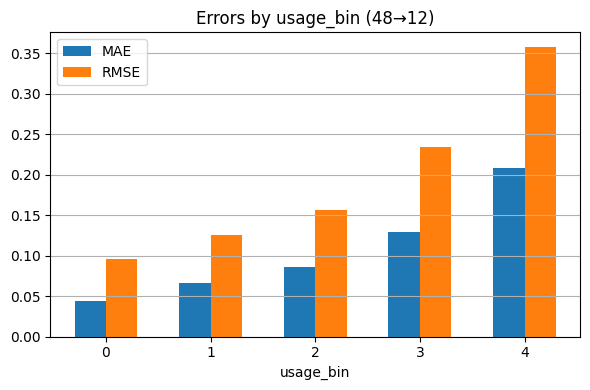

In [17]:
# Metrics by usage_bin (index 10)
USAGE_BIN_IDX = 10
bins = X_test[:, -1, USAGE_BIN_IDX].astype(int)
rows = []
for b in np.sort(np.unique(bins)):
    m = (bins == b)
    yt, yp = y_test[m], y_pred[m]
    if yt.size == 0:
        continue
    rows.append({
        'usage_bin': int(b),
        'MAE': mean_absolute_error(yt, yp),
        'RMSE': math.sqrt(mean_squared_error(yt, yp)),
        'R2': r2_score(yt, yp)
    })
by_bin = pd.DataFrame(rows).sort_values('usage_bin')
by_bin.to_csv(os.path.join(BASE_PATH, "LiteFormer_metrics_by_usage_bin_48_12.csv"), index=False)
print(by_bin)

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(by_bin['usage_bin']-0.15, by_bin['MAE'],  width=0.3, label='MAE')
ax.bar(by_bin['usage_bin']+0.15, by_bin['RMSE'], width=0.3, label='RMSE')
ax.set_xlabel('usage_bin'); ax.set_title('Errors by usage_bin (48→12)')
ax.grid(True, axis='y'); ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(BASE_PATH, "LiPFormer_errors_by_usage_bin_48_12.png"))
plt.show()

In [18]:
# Residual diagnostics by hour-of-day (index 5)
HOUR_IDX = 5
hours    = np.rint(X_test[:, -1, HOUR_IDX] * 23).astype(int).clip(0, 23)
resid    = (y_test - y_pred).reshape(len(y_test), 12)
abs_res  = np.abs(resid).mean(axis=1)
df_hr = pd.DataFrame({'hour': hours, 'abs_resid': abs_res})
by_hr = df_hr.groupby('hour', as_index=False)['abs_resid'].mean()
by_hr.to_csv(os.path.join(BASE_PATH, "LiteFormer_abs_residual_by_hour_48_12.csv"), index=False)
print(by_hr.head())


   hour  abs_resid
0     0   0.058933
1    23   0.107920


In [19]:
# Inference time
sample_input = tf.convert_to_tensor(X_test[:1])
t0 = timeit.default_timer(); _ = model(sample_input); t1 = timeit.default_timer()
inference_time = (t1 - t0) * 1000.0


In [20]:
# Log
gpus = GPUtil.getGPUs()
log_data = {
    "model_name": "LiteFormer_Final_48_12",
    "task": "Smart Meter Energy Forecasting",
    "tuning_type": "BayesianOptimization",
    "test_mae": float(test_mae),
    "test_rmse": float(test_rmse),
    "test_r2": float(test_r2),
    "params": int(model.count_params()),
    "model_size_mb_savedmodel": float(size_savedmodel_mb),
    "model_size_mb_h5": float(size_h5_mb) if size_h5_mb is not None else None,
    "model_size_mb_keras": float(size_keras_mb) if size_keras_mb is not None else None,
    "inference_time_ms": float(inference_time),
    "training_time_minutes": round((end_time - start_time) / 60, 2),
    "input_shape": list(map(int, X_train.shape[1:])),
    # LiteFormer HPs
    "patch_size":    int(best_hps["patch_size"]),
    "hidden_dim":    int(best_hps["hidden_dim"]),
    "dropout":       float(best_hps["dropout"]),
    "learning_rate": float(best_hps["learning_rate"]),
    "system_info": {
        "platform": platform.system(),
        "platform_version": platform.version(),
        "processor": platform.processor(),
        "gpu_used": gpus[0].name if gpus else "None"
    }
}
with open(os.path.join(BASE_PATH, "LiteFormer_Final_Log_48_12.json"), "w") as f:
    json.dump(log_data, f, indent=4)


In [21]:
# Saving predictions
np.savetxt(os.path.join(BASE_PATH, "LiteFormer_y_pred_48_12.csv"), y_pred, delimiter=",")


In [22]:
# CPU-only SavedModel + TFLite
tf.keras.backend.clear_session()
gc.collect()
try:
    tf.config.experimental.set_visible_devices([], 'GPU')
    print(" GPU hidden for CPU rebuild.")
except Exception as e:
    print("⚠ Could not hide GPU (not critical):", e)

with tf.device("/CPU:0"):
    cpu_model = build_liteformer_from_hp(input_shape, best_hps)
    cpu_model.load_weights(WEIGHTS_PATH)

SAVE_DIR_CPU = os.path.join(BASE_PATH, "Final_LiteFormer_Model_48_12_CPU_clean")
cpu_model.export(SAVE_DIR_CPU)
print(" CPU-only SavedModel at:", SAVE_DIR_CPU)

# TFLite convert
converter = tf.lite.TFLiteConverter.from_saved_model(SAVE_DIR_CPU)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
try:
    tflite_model = converter.convert()
except Exception as e:
    print("Builtins-only failed, retrying with SELECT_TF_OPS. Error:", e)
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    tflite_model = converter.convert()

TFLITE_PATH = os.path.join(BASE_PATH, "Final_LiteFormer_Model_48_12.tflite")
with open(TFLITE_PATH, "wb") as f:
    f.write(tflite_model)
print(f" TFLite model saved at: {TFLITE_PATH}")

⚠ Could not hide GPU (not critical): Visible devices cannot be modified after being initialized


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/content/drive/MyDrive/EdgeMeter_AIv2/data/Final_LiteFormer_Model_48_12_CPU_clean'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 11), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  133657439367632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657439366096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657439368208: TensorSpec(shape=(4, 96), dtype=tf.float32, name=None)
  133657439366480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657439364368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657439370320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657439364560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657439371088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657439364944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657439370896: Te

In [23]:
# Quick TFLite sanity check
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()
inp = interpreter.get_input_details()[0]
out = interpreter.get_output_details()[0]
sample = X_test[:1].astype(np.float32)
interpreter.set_tensor(inp["index"], sample)
interpreter.invoke()
pred = interpreter.get_tensor(out["index"])
print("TFLite inference OK | Output shape:", pred.shape)
print("First prediction row:", pred[0])

TFLite inference OK | Output shape: (1, 12)
First prediction row: [0.10609607 0.12374437 0.12409677 0.11835799 0.1250844  0.10268509
 0.12712933 0.14554197 0.11084259 0.1072045  0.11597467 0.13159227]


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
